In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits

# For simulation
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

Gate error ratio: {'x': 1.0, 'rz': 0.0, 'sx': 1.0}


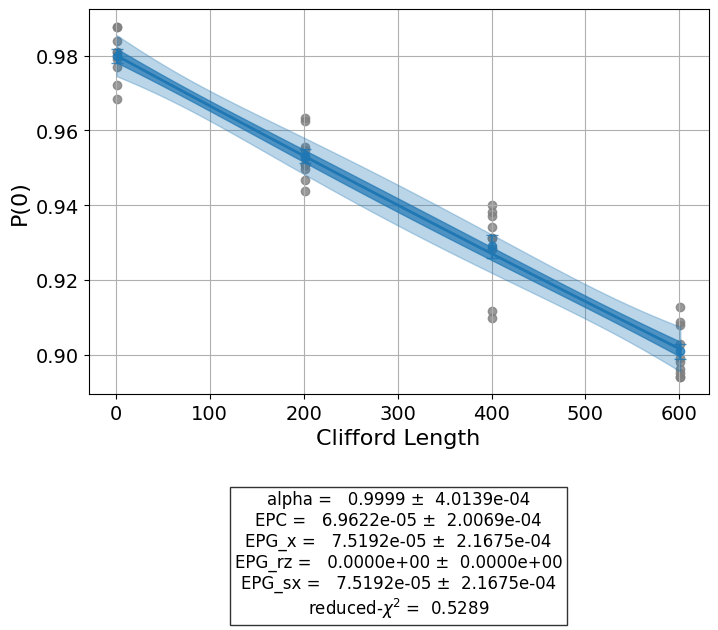

AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 47
 - degree of freedom: 1
 - chi-square: 0.5289458066570836
 - reduced chi-square: 0.5289458066570836
 - Akaike info crit.: -2.0926546334968137
 - Bayesian info crit.: -3.933771550137142
 - init params:
  * a = 0.47994861874112205
  * alpha = 0.9997005081653976
  * b = 0.5
 - fit params:
  * a = 0.9801540983556556 ± 2.7078408183598075
  * alpha = 0.9998607555186273 ± 0.0004013878220969368
  * b = 5.3509200191996965e-15 ± 2.7087774241423146
 - correlations:
  * (a, b) = -0.9999998270689959
  * (alpha, b) = -0.9999297073640107
  * (a, alpha) = 0.9999244108887423
- quality: good
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: alpha
- value: 0.9999+/-0.0004
- χ²: 0.5289458066570836
- quality: good
- device_components: ['Q0']
- verified: False
AnalysisResul

In [3]:
lengths = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = [0]

# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

# View result data
print("Gate error ratio: %s" % expdata1.experiment.analysis.options.gate_error_ratio)
display(expdata1.figure(0))
for result in results1:
    print(result)

In [4]:
lengths_2_qubit = np.arange(1, 200, 30)
lengths_1_qubit = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = (1, 2)

# Run a 1-qubit RB experiment on qubits 1, 2 to determine the error-per-gate of 1-qubit gates
single_exps = BatchExperiment(
    [
        StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
        for qubit in qubits
    ],
    flatten_results=True,
)
expdata_1q = single_exps.run(backend).block_for_results()

Gate error ratio: {'cx': 1.0}


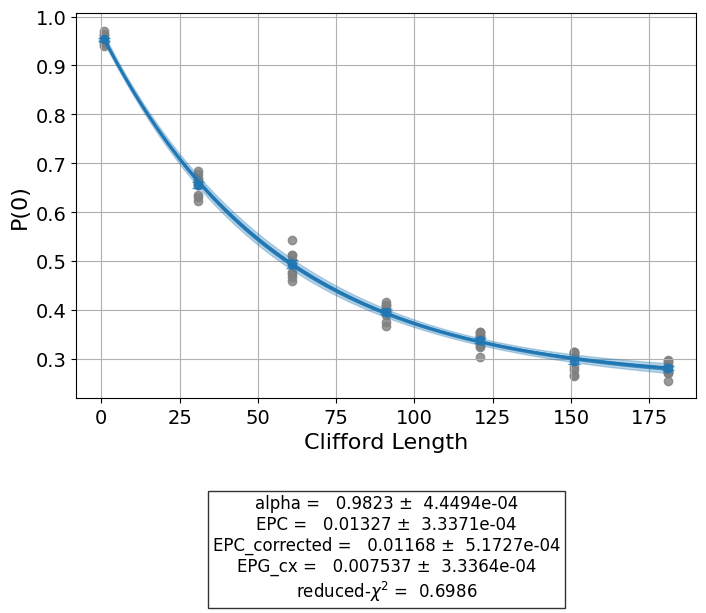

AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 5
 - degree of freedom: 4
 - chi-square: 2.794211784832921
 - reduced chi-square: 0.6985529462082303
 - Akaike info crit.: -0.42852063857212475
 - Bayesian info crit.: -0.5907901914061853
 - init params:
  * a = 0.7158605313724683
  * alpha = 0.9826822178412966
  * b = 0.25
 - fit params:
  * a = 0.7129349504868348 ± 0.005645843964197083
  * alpha = 0.9823054001105757 ± 0.00044494037760351536
  * b = 0.2526019474754891 ± 0.005319025532448459
 - correlations:
  * (alpha, b) = -0.8706180735354851
  * (a, b) = -0.8445377503526755
  * (a, alpha) = 0.6489569193540627
- quality: good
- device_components: ['Q1', 'Q2']
- verified: False
AnalysisResult
- name: alpha
- value: 0.9823+/-0.0004
- χ²: 0.6985529462082303
- quality: good
- device_components: ['Q1', 'Q2']
- verified: False


In [5]:
# Run an RB experiment on qubits 1, 2
exp_2q = StandardRB(qubits, lengths_2_qubit, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp_2q.analysis.set_options(epg_1_qubit=expdata_1q.analysis_results())

# Run the 2-qubit experiment
expdata_2q = exp_2q.run(backend).block_for_results()

# View result data
print("Gate error ratio: %s" % expdata_2q.experiment.analysis.options.gate_error_ratio)
display(expdata_2q.figure(0))
for result in expdata_2q.analysis_results():
    print(result)

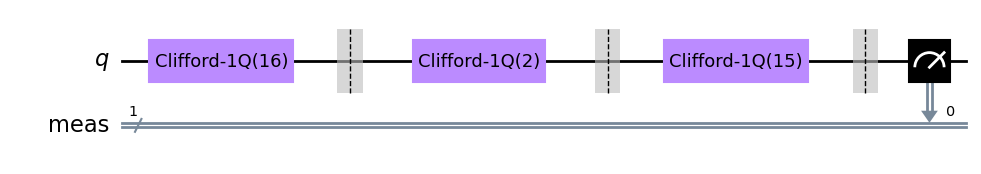

In [6]:
# Run an RB experiment on qubit 0
exp = StandardRB(physical_qubits=(0,), lengths=[2], num_samples=1, seed=seed)
c = exp.circuits()[0]
c.draw("mpl")

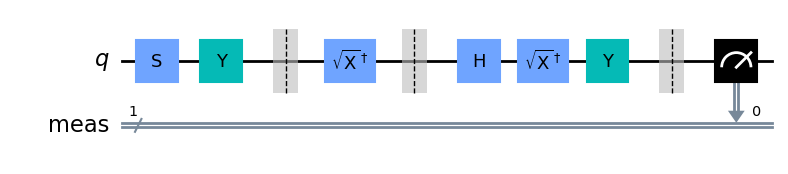

In [7]:
c.decompose().draw("mpl")

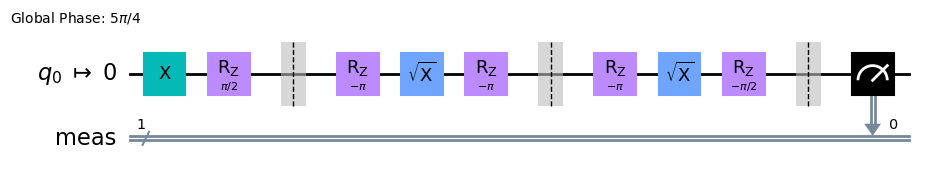

In [8]:
from qiskit import transpile
transpile(c, backend, **vars(exp.transpile_options)).draw("mpl", idle_wires=False)

In [9]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1, 2)

# The interleaved gate is the CX gate
int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

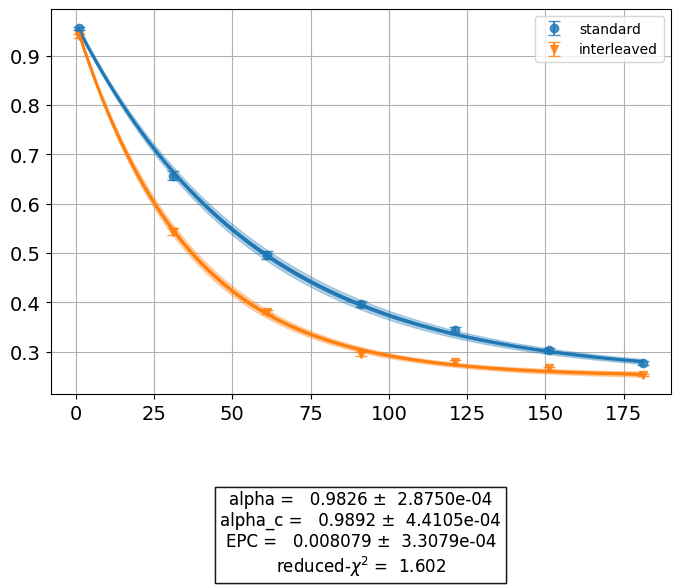

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 5
 - degree of freedom: 10
 - chi-square: 16.021903531468027
 - reduced chi-square: 1.6021903531468027
 - Akaike info crit.: 9.88859198017242
 - Bayesian info crit.: 12.444821298633453
 - init params:
  * a = 0.7152225498629672
  * alpha = 0.9820890453840424
  * b = 0.25
  * alpha_c = 0.9877946487802182
 - fit params:
  * a = 0.7147034807546795 ± 0.00276473758739418
  * alpha = 0.9826128710343012 ± 0.00028749906782739624
  * b = 0.2505723201895498 ± 0.001963207518317782
  * alpha_c = 0.9892277297476174 ± 0.0004410544805241053
 - correlations:
  * (a, b) = -0.6275760842385913
  * (alpha, b) = -0.5595815994160639
  * (b, alpha_c) = -0.3134638562866739
  * (alpha, alpha_c) = -0.24902576138232949
  * (a, alpha_c) 

In [10]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)